In [7]:
from kaffe.tensorflow import Network
import tensorflow as tf
import numpy as np
import os
import csv
from tqdm import tqdm_notebook
import sys
import matplotlib.pyplot as plt
import itertools
%pylab inline

/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Populating the interactive namespace from numpy and matplotlib


/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
batch_size = 64
num_workers=4
VGG_MEAN = [123.68, 116.78, 103.94]

In [3]:
gender_mapping = {'':2, 'f':1, 'm':0, 'u':2}

def list_images(path, base_path, prefix):
    """
    Get all the images and labels in directory/label/*.jpg
    """
    filenames=[]
    labels=[]
    
    with open(path) as fp:
        next(fp) #skip csv header
        for row in csv.reader(fp, delimiter="\t"):
            fn=row[1]
            uid=row[0]
            gender=gender_mapping[row[4]]
            x=row[2]+"."#"1."
            
            filenames.append(base_path+uid+"/"+prefix+x+fn)
            labels.append(gender)
            
    return filenames, labels
            
            

images_path = "../data/fold_0_data.txt"
base_path = "../data/aligned/"
prefix="landmark_aligned_face."
train_filenames, train_labels = list_images(images_path, base_path, prefix)

val_images_path = "../data/fold_1_data.txt"
val_filenames, val_labels = list_images(val_images_path, base_path, prefix)

In [4]:
train_filenames[0], set(train_labels)

('../data/aligned/30601258@N03/landmark_aligned_face.1.10399646885_67c7d20df9_o.jpg',
 {0, 1, 2})

In [5]:
# Preprocessing (for both training and validation):
# (1) Decode the image from jpg format
# (2) Resize the image so its smaller side is 256 pixels long
def _parse_function(filename, label):
    image_string = tf.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)          # (1)
    image = tf.cast(image_decoded, tf.float32)

    smallest_side = 256.0
    height, width = tf.shape(image)[0], tf.shape(image)[1]
    height = tf.to_float(height)
    width = tf.to_float(width)

    scale = tf.cond(tf.greater(height, width),
                    lambda: smallest_side / width,
                    lambda: smallest_side / height)
    new_height = tf.to_int32(height * scale)
    new_width = tf.to_int32(width * scale)

    resized_image = tf.image.resize_images(image, [new_height, new_width])  # (2)
    return resized_image, label

# Preprocessing (for training)
# (3) Take a random 224x224 crop to the scaled image
# (4) Horizontally flip the image with probability 1/2
# (5) Substract the per color mean `VGG_MEAN`
# Note: we don't normalize the data here, as VGG was trained without normalization
def training_preprocess(image, label):
    crop_image = tf.random_crop(image, [224, 224, 3])                       # (3)
    flip_image = tf.image.random_flip_left_right(crop_image)                # (4)

    means = tf.reshape(tf.constant(VGG_MEAN), [1, 1, 3])
    centered_image = flip_image - means                                     # (5)

    return centered_image, label

# Preprocessing (for validation)
# (3) Take a central 224x224 crop to the scaled image
# (4) Substract the per color mean `VGG_MEAN`
# Note: we don't normalize the data here, as VGG was trained without normalization
def val_preprocess(image, label):
    crop_image = tf.image.resize_image_with_crop_or_pad(image, 224, 224)    # (3)

    means = tf.reshape(tf.constant(VGG_MEAN), [1, 1, 3])
    centered_image = crop_image - means                                     # (4)

    return centered_image, label

In [6]:
# Training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames, train_labels))
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=num_workers)
train_dataset = train_dataset.map(training_preprocess, num_parallel_calls=num_workers)
#train_dataset = train_dataset.shuffle(buffer_size=1000)  # don't forget to shuffle
batched_train_dataset = train_dataset.batch(batch_size)

In [7]:
# Validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((val_filenames, val_labels))
val_dataset = val_dataset.map(_parse_function,
    num_parallel_calls=num_workers)
val_dataset = val_dataset.map(val_preprocess,
    num_parallel_calls=num_workers)
batched_val_dataset = val_dataset.batch(batch_size)

In [8]:
iterator = tf.data.Iterator.from_structure(batched_train_dataset.output_types,
                                                   batched_train_dataset.output_shapes)
images, labels = iterator.get_next()

train_init_op = iterator.make_initializer(batched_train_dataset)
val_init_op = iterator.make_initializer(batched_val_dataset)

# Indicates whether we are in training or in test mode
is_training = tf.placeholder(tf.bool)

In [9]:
class VGG_FACE_16_layers(Network):
    def setup(self):
        (self.feed('input')
             .conv(3, 3, 64, 1, 1, name='conv1_1')
             .conv(3, 3, 64, 1, 1, name='conv1_2')
             .max_pool(2, 2, 2, 2, name='pool1')
             .conv(3, 3, 128, 1, 1, name='conv2_1')
             .conv(3, 3, 128, 1, 1, name='conv2_2')
             .max_pool(2, 2, 2, 2, name='pool2')
             .conv(3, 3, 256, 1, 1, name='conv3_1')
             .conv(3, 3, 256, 1, 1, name='conv3_2')
             .conv(3, 3, 256, 1, 1, name='conv3_3')
             .max_pool(2, 2, 2, 2, name='pool3')
             .conv(3, 3, 512, 1, 1, name='conv4_1')
             .conv(3, 3, 512, 1, 1, name='conv4_2')
             .conv(3, 3, 512, 1, 1, name='conv4_3')
             .max_pool(2, 2, 2, 2, name='pool4')
             .conv(3, 3, 512, 1, 1, name='conv5_1')
             .conv(3, 3, 512, 1, 1, name='conv5_2')
             .conv(3, 3, 512, 1, 1, name='conv5_3')
             .max_pool(2, 2, 2, 2, name='pool5')
             .fc(4096, name='fc6')
             .fc(4096, name='fc7')
             .fc(3, relu=False, name='fc8')
             .softmax(name='prob'))

In [10]:
net = VGG_FACE_16_layers({'input': images})
logits = net.layers["fc8"]
net.layers

{'conv1_1': <tf.Tensor 'conv1_1/conv1_1:0' shape=(?, 224, 224, 64) dtype=float32>,
 'conv1_2': <tf.Tensor 'conv1_2/conv1_2:0' shape=(?, 224, 224, 64) dtype=float32>,
 'conv2_1': <tf.Tensor 'conv2_1/conv2_1:0' shape=(?, 112, 112, 128) dtype=float32>,
 'conv2_2': <tf.Tensor 'conv2_2/conv2_2:0' shape=(?, 112, 112, 128) dtype=float32>,
 'conv3_1': <tf.Tensor 'conv3_1/conv3_1:0' shape=(?, 56, 56, 256) dtype=float32>,
 'conv3_2': <tf.Tensor 'conv3_2/conv3_2:0' shape=(?, 56, 56, 256) dtype=float32>,
 'conv3_3': <tf.Tensor 'conv3_3/conv3_3:0' shape=(?, 56, 56, 256) dtype=float32>,
 'conv4_1': <tf.Tensor 'conv4_1/conv4_1:0' shape=(?, 28, 28, 512) dtype=float32>,
 'conv4_2': <tf.Tensor 'conv4_2/conv4_2:0' shape=(?, 28, 28, 512) dtype=float32>,
 'conv4_3': <tf.Tensor 'conv4_3/conv4_3:0' shape=(?, 28, 28, 512) dtype=float32>,
 'conv5_1': <tf.Tensor 'conv5_1/conv5_1:0' shape=(?, 14, 14, 512) dtype=float32>,
 'conv5_2': <tf.Tensor 'conv5_2/conv5_2:0' shape=(?, 14, 14, 512) dtype=float32>,
 'conv5_3'

In [17]:
fc8_variables = tf.contrib.framework.get_variables('fc8')
fc8_init = tf.variables_initializer(fc8_variables)

fc8_variables

[<tf.Variable 'fc8/weights:0' shape=(4096, 3) dtype=float32_ref>,
 <tf.Variable 'fc8/biases:0' shape=(3,) dtype=float32_ref>]

In [18]:
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels))
opt = tf.train.AdamOptimizer()
fc8_train_op = opt.minimize(loss, var_list=fc8_variables)

In [11]:
saver = tf.train.Saver()

In [12]:
sess = tf.Session()

In [14]:
%%time 

# Load the data
sess.run(tf.global_variables_initializer())
sess.run(fc8_init)  # initialize the new fc8 layer
sess.run(train_init_op)
net.load('./VGG_FACE.npy', sess, scratch_layers=["prob", "fc8"]) #restore weights except for last FC
    

CPU times: user 2.79 s, sys: 1.4 s, total: 4.19 s
Wall time: 4.25 s


In [15]:
def check_accuracy(sess, correct_prediction, is_training, dataset_init_op):
    """
    Check the accuracy of the model on either train or val (depending on dataset_init_op).
    """
    # Initialize the correct dataset
    num_classes=3
    sess.run(dataset_init_op)
    num_correct, num_samples = 0, 0
    cfm_agg = np.zeros((num_classes, num_classes), dtype=int32)
    while True:
        try:
            correct_pred, cfm = sess.run([correct_prediction, confusion_matrix], {is_training: False})
            num_correct += correct_pred.sum()
            num_samples += correct_pred.shape[0]
            
            cfm_agg +=cfm
            
            
        except tf.errors.OutOfRangeError:
            break

    # Return the fraction of datapoints that were correctly classified
    acc = float(num_correct) / num_samples
    
    return acc, cfm_agg

In [16]:
# Evaluation metrics
prediction = tf.to_int32(tf.argmax(logits, 1))
correct_prediction = tf.equal(prediction, labels)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
confusion_matrix = tf.confusion_matrix(labels, prediction, num_classes=3)

In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [18]:
class_names=["M", "F", "?"]
np.set_printoptions(precision=2)

def epoch_eval():
    # Check initial accuracy
    train_acc, train_cnf_matrix = check_accuracy(sess, correct_prediction, is_training, train_init_op)
    val_acc, val_cnf_matrix = check_accuracy(sess, correct_prediction, is_training, val_init_op)
    print('Train accuracy: %f' % train_acc)
    print('Val accuracy: %f\n' % val_acc)
    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(val_cnf_matrix, class_names,normalize=True,title='Normalized Confusion matrix')
    plt.show()

Train accuracy: 0.243310
Val accuracy: 0.309115

Normalized confusion matrix


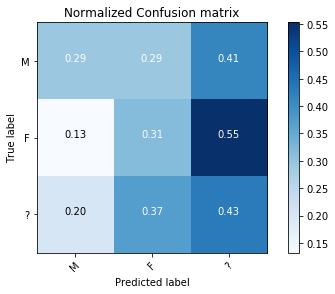

Starting epoch 1 / 10


Train accuracy: 0.876004
Val accuracy: 0.805630

Normalized confusion matrix


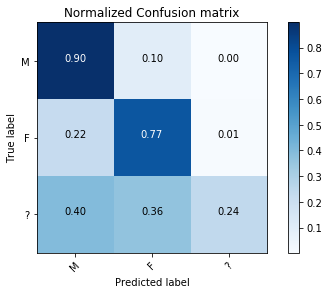

Starting epoch 2 / 10


Train accuracy: 0.914139
Val accuracy: 0.794370

Normalized confusion matrix


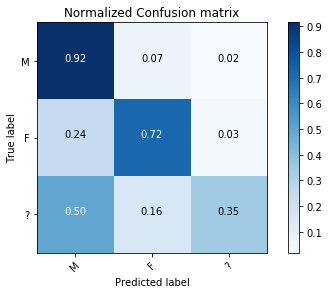

Starting epoch 3 / 10


Train accuracy: 0.956289
Val accuracy: 0.830563

Normalized confusion matrix


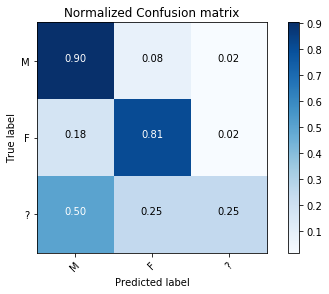

Starting epoch 4 / 10


Train accuracy: 0.968555
Val accuracy: 0.837265

Normalized confusion matrix


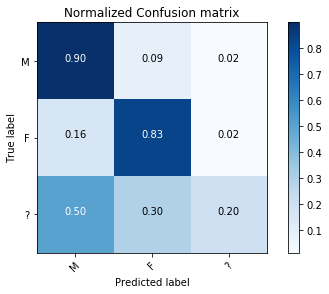

Starting epoch 5 / 10


Train accuracy: 0.978368
Val accuracy: 0.842627

Normalized confusion matrix


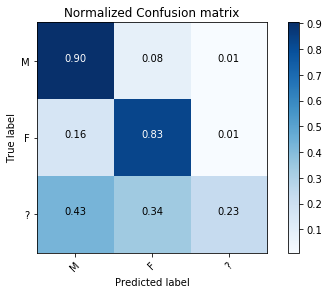

Starting epoch 6 / 10


Train accuracy: 0.978591
Val accuracy: 0.833512

Normalized confusion matrix


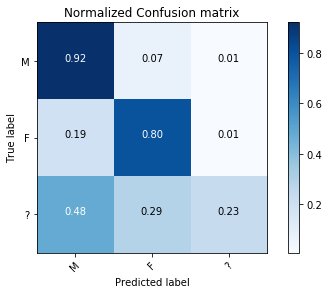

Starting epoch 7 / 10


Train accuracy: 0.978145
Val accuracy: 0.830563

Normalized confusion matrix


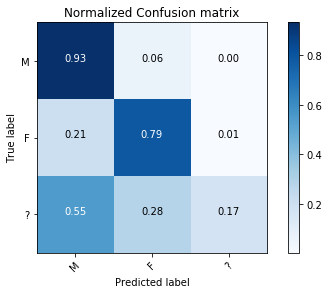

Starting epoch 8 / 10


Train accuracy: 0.978814
Val accuracy: 0.825201

Normalized confusion matrix


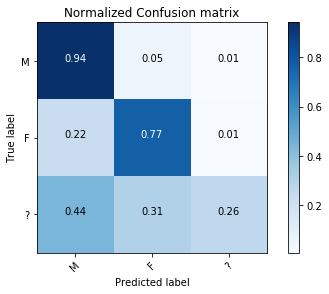

Starting epoch 9 / 10


Train accuracy: 0.980821
Val accuracy: 0.832976

Normalized confusion matrix


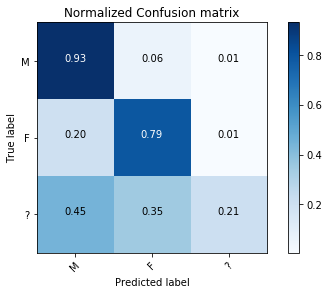

Starting epoch 10 / 10


Train accuracy: 0.985727
Val accuracy: 0.830831

Normalized confusion matrix


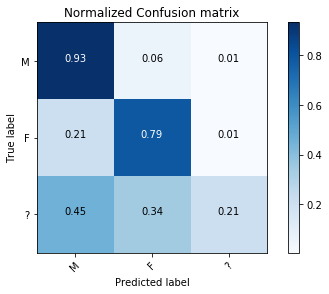

In [19]:
num_epochs1=10

epoch_eval()

for epoch in range(num_epochs1):
    print('Starting epoch %d / %d' % (epoch + 1, num_epochs1))
    sess.run(train_init_op)
    
    epoch_losses=[]
    
    pbar = tqdm_notebook(total = len(train_filenames)//batch_size)
    while True:
        try:
            _, xent = sess.run([fc8_train_op, loss], {is_training: True})
            epoch_losses.append(xent)
            pbar.update(1)
            pbar.set_description("mean epoch loss(xent): %f" % (np.mean(epoch_losses)))
        except tf.errors.OutOfRangeError:
            break
            

    epoch_eval()
    
save_path = saver.save(sess, "./ckpts/model.ckpt")
    


In [13]:
saver.restore(sess, "./ckpts/model.ckpt")

INFO:tensorflow:Restoring parameters from ./ckpts/model.ckpt


In [16]:
def plot_history_gg(history):
    plt.style.use('ggplot')
    acc = history['acc']
    val_acc =history['val_acc']

    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation acc')
    plt.legend()
    plt.show()

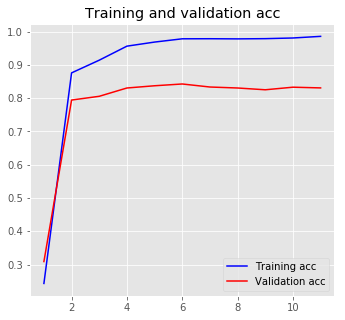

In [17]:
train=[0.243310, 0.876004, 0.914139, 0.956289, 0.968555, 0.978368, 0.978591, 0.978145, 0.978814, 0.980821, 0.985727]
test=[0.309115, 0.794370, 0.805630, 0.830563, 0.837265, 0.842627, 0.833512, 0.830563, 0.825201, 0.832976, 0.830831]
history={'acc': train, 'val_acc': test}
plot_history_gg(history)